# Numerical Stability of Stepping Methods for Ordinary Differential Equations

TMA4125 Vår 2022

This notebook accompanies the slides [06c-Numerical-stability-in-ODEs.pdf](https://www.math.ntnu.no/emner/TMA4125/2022v/lecture-notes/06c-Numerical-stability-in-ODEs.pdf).

In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from numpy.linalg import norm

# Numerical algorithms
Let's implement simple routines to solve ODEs numerically, based on different methods seen in class

### Explicit Euler 
The algorithm for Euler's method looks like

In [2]:
# Define Euler's method
def Euler(y0, T, f, h):
    """
        Euler(y0, T, f, h)
    
    Use Euler's method to approximate the solution of the ODE (scalar or system) y'(t) = f(t,y)
    
    Input:
        y0 - initial value y(0)
        f  - definition of the right-hand-side function
        T  - simulation time (starting at t=0, ending at t=T)
        h  - time-step size (fixed)
    Output:
        y  - array containing all discrete solution values y0,y1,y2,...
        t  - array containing all discrete time instants 0,h,2h,...
    """
    ys = [y0] #array where all y_n will be stored
    ts = [0]  #array where all t_n will be stored
    while(ts[-1] < T):
        t, y = ts[-1], ys[-1]
        ys.append(y + h*f(t, y))
        ts.append(t + h)
    return (np.array(ts), np.array(ys))

### Heun's method
The algorithm for Heun's method looks like

In [3]:
# Define Heun's method
def Heun(y0, T, f, h):
    """
        Heun(y0, T, f, h)
    
    Use Heun's method to approximate the solution of the ODE (scalar or system) y'(t) = f(t,y)
    
    Input:
        y0 - initial value y(0)
        f  - definition of the right-hand-side function
        T  - simulation time (starting at t=0, ending at t=T)
        h  - time-step size (fixed)
    Output:
        y  - array containing all discrete solution values y0,y1,y2,...
        t  - array containing all discrete time instants 0,h,2h,...
    """
    ys = [y0] #array where all y_n will be stored
    ts = [0]  #array where all t_n will be stored
    while(ts[-1] < T):
        t, y = ts[-1], ys[-1]
        f1 = f(t,y)
        f2 = f(t+h, y+h*f1)
        ys.append(y + 0.5*h*(f1+f2))
        ts.append(t + h)
    return (np.array(ts), np.array(ys))

### Implicit Euler
For a nonlinear ODE $y'(t) = f(t,y(t))$, the implicit Euler method requires an additional loop: at each time step, we need to use an iterative method to find $y_{n+1}$. The nonlinear equation to be solved is
\begin{align*}
y_{n+1} = y_n + hf(t_{n}+h,y_{n+1})\, . \vphantom{\sqrt{\frac{1}{2}}}
\end{align*}
Since $y_n$ and $t_{n}$ are already known at this point, we can define $g(y_{n+1}) := y_n + hf(t_{n}+h,y_{n+1})$, so that
\begin{align*}
y_{n+1} = g(y_{n+1})\, ,
\end{align*}
which is already in the form we need when applying, for example, a fixed-point iteration. This is what we implement below:

In [4]:
# Define the implicit Euler method
def implicitEuler(y0, T, f, h):
    """
        implicitEuler(y0, T, f, h)
    
    Use the implicit Euler method to approximate the solution of the ODE (scalar or system) y'(t) = f(t,y(t))
    
    Input:
        y0 - initial value y(0)
        f  - definition of the right-hand-side function
        T  - simulation time (starting at t=0, ending at t=T)
        h  - time-step size (fixed)
    Output:
        y  - array containing all discrete solution values y0,y1,y2,...
        t  - array containing all discrete time instants 0,h,2h,...
    """
    ys = [y0] #array where all y_n will be stored
    ts = [0]  #array where all t_n will be stored
    tol = 1e-6 #set the tolerance of the fixed-point iteration
    cMax = 50 #set the maximum number of fixed-point iterations allowed at each time step
    while(ts[-1] < T):
        t, y_n = ts[-1], ys[-1] 
        err = 1000 #define the error as a large number before starting the iterations
        c = 0 #re-set iteration count at each time step
        y = y_n #set y_n as the starting point for the iterative method
        while err > tol and c < cMax: #stop iterations when reaching the tolerance OR the maximum iteration count
            c = c + 1 
            y = y_n + h*f(t+h,y)
            err = norm(y-y_n-h*f(t+h,y))
        ys.append(y)
        ts.append(t + h)
    return (np.array(ts), np.array(ys))

### Implicit Euler for a linear ODE
For the linear ODE $y' = k y$, we get a closed-form expression for each implicit Euler step:
\begin{align*}
y_{n+1} = y_n + hf(t_{n+1},y_{n+1}) = y_n + h k y_{n+1} \quad \Rightarrow \quad y_{n+1} = \frac{y_n}{1-hk}\, . \vphantom{\sqrt{\frac{1}{2}}}
\end{align*}
This allows a simpler implementation:

In [5]:
# Define the implicit Euler method for the scalar, linear model problem
def implicitEulerLinear(y0, T, k, h):
    """
        implicitEuler(y0, T, f, h)
    
    Use the implicit Euler method to approximate the solution of the linear, scalar ODE y'(t) = k*y(t)
    
    Input:
        y0 - initial value y(0)
        k  - linear ODE coefficient
        T  - simulation time (starting at t=0, ending at t=T)
        h  - time-step size (fixed)
    Output:
        y  - array containing all discrete solution values y0,y1,y2,...
        t  - array containing all discrete time instants 0,h,2h,...
    """
    ys = [y0] #array where all y_n will be stored
    ts = [0]  #array where all t_n will be stored
    while(ts[-1] < T):
        t, y = ts[-1], ys[-1]
        ys.append(y/(1-k*h))
        ts.append(t + h)
    return (np.array(ts), np.array(ys))

# Numerical examples

## Linear scalar ODE
To test the stability of our methods, let's consider the linear problem
\begin{align*}
y'(t) = ky(t), \quad y(0) = y_0\, .
\end{align*}
This problem has a known exact solution: 
\begin{align*}
y(t) = y_0\mathrm{e}^{kt}\, ,
\end{align*}
which exhibits a decaying behaviour for $k < 0$.

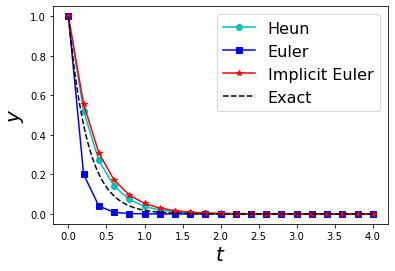

In [6]:
# Problem data
y0 = 1 #initial value
k = -4 #linear coefficient

# Solver settings
T = 4 #Final simulation time
h = .2 #Time-step size

# Define right-hand-side function
def f(t,y):
    return  k*y

# Numerical solution via different methods
tHeun, yHeun = Heun(y0, T, f, h)
tEuler, yEuler = Euler(y0, T, f, h)
tImplicitEuler, yImplicitEuler = implicitEulerLinear(y0, T, k, h) 

#Plot numerical solutions
plt.plot(tHeun, yHeun, 'o-c')
plt.plot(tEuler, yEuler, 's-b')
plt.plot(tImplicitEuler, yImplicitEuler, '*-r')


#Plot exact solution 
t = np.linspace(0,T,1000);
plt.plot(t,y0*np.exp(k*t),'--k')

#Axis and legend for the plots
plt.legend(['Heun','Euler', 'Implicit Euler',  'Exact'], fontsize = 16)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$y$', fontsize = 20)
plt.rcParams['figure.figsize'] = [15, 6]

## Linear ODE system
In this example, we will check the stability of the explicit Euler method when solving the linear ODE system $\mathbf{y}'(t) = A\mathbf{y}(t)$, in which
\begin{align*}
A = 
\begin{pmatrix}
0 & 1 \\
-2 & -3
\end{pmatrix} \quad \mathrm{and} \quad \mathbf{y}(0) = 
\begin{pmatrix}
1 \\ 0
\end{pmatrix}\, .
\end{align*}
As seen in class, this can represent the electrodynamics of an RLC circuit. For this problem, we have the analytical solution
\begin{align*}
\mathbf{y}(t) = 
\begin{pmatrix}
2\mathrm{e}^{-t} - \mathrm{e}^{-2t}  \\
2\mathrm{e}^{-2t} - 2\mathrm{e}^{-t}
\end{pmatrix}\, ,
\end{align*}
with the first entry in $\mathbf{y}$ denoting the electric current $i(t)$, and the second entry being $i'(t)$.

Text(0, 0.5, 'electric current')

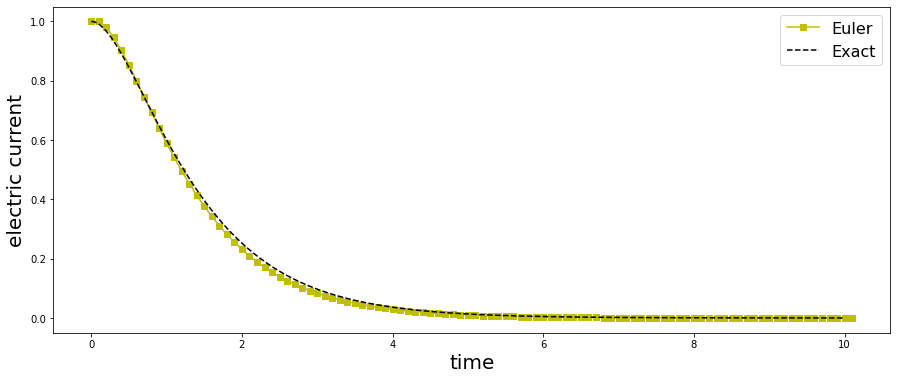

In [7]:
# Problem data
y0 = np.array([1, 0]) #initial condition
A = np.array(
         [[0, 1],
         [-2,    -3]]) #coefficient matrix

# Solver settings
T = 10 #Total simulation time
h = .1 #Time-step size

# Define right-hand-side function f(t,y) = A*y
def f(t,y):
    return  np.dot(A,y)

# Numerical solution via Euler's method (explicit)
tEuler, yEuler = Euler(y0, T, f, h)

# Plot numerical solution (first component only, which represents the electric current)
plt.plot(tEuler, yEuler[:,0], 's-y')

#Plot exact solution 
t = np.linspace(0,T,1000);
plt.plot(t,2*np.exp(-t)-np.exp(-2*t),'--k')

#Axis and legend for the plots
plt.legend(['Euler', 'Exact'], fontsize = 16)
plt.xlabel('time', fontsize = 20)
plt.ylabel('electric current', fontsize = 20)